# Sales Forecast Using LSTM

In [ ]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#pip install keras
#pip install tensorflow

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly as py

In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [ ]:
xls = pd.ExcelFile('Monthly Sales for Laptops - Project Data.xlsx')
xls.sheet_names

In [ ]:
df = pd.read_excel (xls)
df.head(10)

In [ ]:
df.info()

In [ ]:
df.Month.hist()

In [ ]:
df.isnull().sum()

In [ ]:
df[df.Sales.isnull()]

In [ ]:
mask=df.Sales.isnull()

df_sales=df[~mask]

In [ ]:
df_sales.isnull().sum()

In [ ]:
df_sales.Month.describe()

1. Plot Monthly Sales

In [ ]:
#plot monthly sales
plot_data = [
    go.Scatter(
        x=df_sales['Month'],
        y=df_sales['Sales'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

In [ ]:
df_sales.tail(12)

There is a strong sales peak at Black-Friday times (November) and Christmas times (December), followed by a dip shortly thereafter.

In [ ]:
#create a new dataframe for model prediction
df_diff= df.copy()
#add previous sales
df_diff['prev_sales'] = df_diff['Sales'].shift(1)
#drop the null values and calculate the difference

#df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Sales'] - df_diff['prev_sales'])
df_diff.tail(24)

2. Plot monthly difference

In [ ]:
#plot sales diff
df_diff2= df_diff.dropna()

plot_data = [
    go.Scatter(
        x=df_diff2['Month'],
        y=df_diff2['diff'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

3. Use previous mothly sales to predict next month

In [ ]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)


In [ ]:
df_supervised.tail(24)

4. Check how well features explains the variation

In [ ]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

Entire features (lag1~12) explains 63% of the variation (not too impressive)

5. Build LSTM Model Test with Actual Sales

In [ ]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['Sales','Budget','Month'],axis=1)

#split train and test set 
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

In [ ]:
df_model.tail(12)

In [ ]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [ ]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
import keras.models
from keras.models import Sequential
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

In [ ]:
y_pred = model.predict(X_test,batch_size=1)

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [ ]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-7:].Month)
act_sales = list(df_sales[-7:].Sales)

    
    

In [ ]:
sales_dates

In [ ]:
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['Month'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [ ]:
df_result.tail()

In [41]:
#conda install -c plotly plotly-orca
#import plotly.io as pio
#pio.renderers.default = "svg"

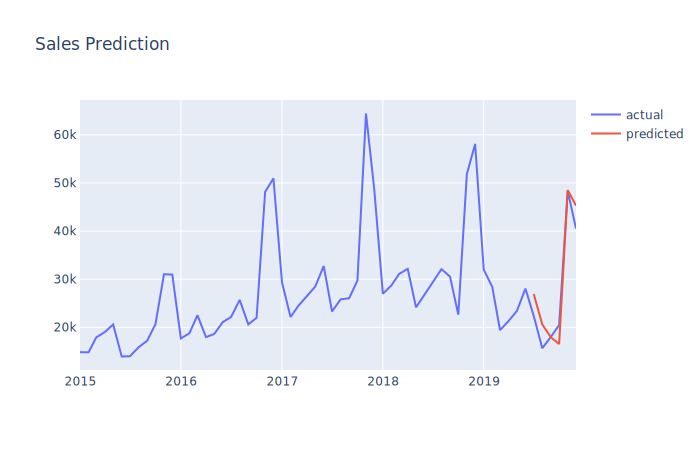

In [39]:

#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='Month',how='left')
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_sales_pred['Month'],
        y=df_sales_pred['Sales'],
        name='actual'
    ),
        go.Scatter(
        x=df_sales_pred['Month'],
        y=df_sales_pred['pred_value'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [ ]:
conda install -c plotly plotly-orca